<a href="https://colab.research.google.com/github/jaekyoungkim/tensor2ml_NLP/blob/main/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%99%80_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%9C%BC%EB%A1%9C_%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94_%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC(ch7_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 

# bert를 활용한 한국어 개체명 인식 모델 

In [37]:
# ner (개체명 인식) 문맥을 파악해서 인명, 기관명, 지명 등과 같은 문장 또는 문서에서 특정한 의미를 가지고 있는 단어 또는 어구를 인식하는 과정을 의미
# 객체명 인식은 버트를 호라용한 감정분 류 및 유사도 분류와 맥락은 거의 비슷
# 이전에 다룬 접근법들은 마지막 히든 벡터값을 사용하는 접근법이었다면 객체명 인식은 문장의 모든 입력값을 개체명으로 예측
# 모든 은닉 벡터값을 활용한다는 차이가 있음
# naver nlp challenge 2018 데이터 활용
# 학습 데이터 81000개, 테스트 데이터 9000개
# 라벨은 총 30개로 구성됨

In [1]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 19.9 MB/s 
     |████████████████████████████████| 895 kB 56.0 MB/s 
     |████████████████████████████████| 6.8 MB 41.4 MB/s 
     |████████████████████████████████| 596 kB 57.4 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!git clone https://github.com/NLP-kr/tensorflow-ml-nlp-tf2.git

Cloning into 'tensorflow-ml-nlp-tf2'...
remote: Enumerating objects: 1725, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 1725 (delta 48), reused 17 (delta 7), pack-reused 1631
Receiving objects: 100% (1725/1725), 201.21 MiB | 18.79 MiB/s, done.
Resolving deltas: 100% (1038/1038), done.
Checking out files: 100% (88/88), done.


In [3]:
# 데이터 불러오기
import os
DATA_IN_PATH = '/content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_in/KOR'
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")

In [4]:

def read_file(input_path):
  """read tst file and return words and label as list"""
  with open(input_path, "r", encoding='utf-8') as f :
    sentences = []
    labels =[]
    for line in f :
      split_line  =  line.strip().split("\t")
      sentences.append(split_line[0])
      labels.append(split_line[1])
    return sentences, labels

In [5]:
train_sentences, train_labels, = read_file(DATA_TRAIN_PATH)
test_sentences, test_labels = read_file(DATA_TEST_PATH)
ner_setences = train_sentences +test_sentences
ner_labels = train_labels + test_labels


In [11]:
train_sentences

['금석객잔 여러분, 감사드립니다 .',
 '이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .',
 '7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권대회 출격권을 점유했다 .',
 '스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서 폭렬적인 평판을 모으고 있는데 치안정감들은 이 곡목에 출연해 인기인이 된 황정민 장두해 장정 풀 포츠가 퇴석했다며 송사를 보내고 있습니다 .',
 '보니까 저 옆에 사조가 있어요 .',
 '24회 최경운호의 좌익선상 28루타로 포문을 연 한화는 후속 서동원이 적시타를 날려 동점에 공성했다 .',
 '바둑선수가 묘하게 닮았는데요 .',
 "▲ '新플레이메이커' NO.7 박하성 - 1경기 30골30도움공수 운동경기가 풀리지 않을 때는 논란에 나서 슈팅까지 경쟁을 풀어나가는 존대성은 코리아바이오파크의 '신(新)해결사'로 터전 잡았다 .",
 '우려는 비현실이 됐다 .',
 '(이석무 귀재 smlee@mydaily.co.kr)',
 '서두가 역할의 소하젓은 다름아닌 쿠마리 씨였대요 .',
 '이렇게 검은색 판을 보여주면 자, 보세요 .',
 '아니， 그보다 고무와 재준 상호 본심을 밝혀내고 증오를 할 수 있을까요 ？',
 '투병중에 선민이 꿈꿔왔던 순수하지만 아픈 증오를 했는데요 .',
 '연변축구팀서 데뷔해 3년 자매원 이관 빚을 발한 임호성은 11년 만년 유망주에서 떡꼬치조림 상처를 꿰찼다 .',
 '그러던 어느 날 김대성은 어린 계절, 불초자 밑에서 꼬봉 노릇이나 하던 남덕기(유해진 분)가 라켓볼선수에 입후보한다는 돈반을 접하게 되고, 묘한 질투심에 사로잡힌다 .',
 '또한, 거세 암학회에 에이즈퇴치캠페인에 동참한 데 이어, 구제 동작을 하는 UN 산하기구인 UNHCR(유엔난민기구)의 에 동참할 계획이다 .',
 '시골의 작은 현으로서는 적지 않은 액수지만 탄광개발로 시의 수입금이 상년부터 28%씩 늘고 있어 감당할 수 있는 수준이라고 설계자

In [12]:
train_labels

['ORG-B O O O',
 'PER-B O O O TIM-B TIM-I CVL-B O O O O O',
 'EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O',
 'LOC-B NUM-B NUM-I O O O O O O O O O O O O O CVL-B O O O CVL-B O PER-B O O O CVL-B O O O O O',
 'O O O O O O',
 'NUM-B PER-B O NUM-B O O ORG-B O PER-B O O O O O',
 'CVL-B O O O',
 'O CVL-B NUM-B PER-B O NUM-B NUM-B O O O O O O O O O PER-B ORG-B CVL-B O O O',
 'O O O O',
 'PER-B CVL-B TRM-B',
 'O O CVL-B O PER-B O O',
 'O TRM-B O O O O O',
 'O O O O O O O O O O O O',
 'O O O O O O O O',
 'ORG-B O DAT-B ORG-B O O O PER-B DAT-B O CVL-B CVL-B O O O',
 'O O O PER-B O O O O O O O PER-B O CVL-B O O O O O O O O',
 'O DAT-B ORG-B EVT-B O O O O O O ORG-B O ORG-B O O O O',
 'O O O O O O O O O DAT-B NUM-B O O O O O O CVL-B O O',
 'PER-B O TRM-B O O O NUM-B CVL-B O',
 'ORG-B ORG-I ORG-B EVT-B LOC-B O',
 'O NUM-B O CVL-B O O O O O O',
 'O PER-B O NUM-B CVL-B O O',
 'LOC-B O O O O O O O O O O O LOC-B O O O O O O O',
 'PER-B O O O O CVL-B O',
 'O O CVL-B O LOC-B O O O O',
 'O ORG-B NUM-B 

In [6]:
import pandas as pd

ner_dict = {"sentence" : ner_setences, "label": ner_labels}
ner_df = pd.DataFrame(ner_dict)


In [7]:
ner_df.head(5)
# 총 14가지 분류가 존재함

,sentence,label
0,"금석객잔 여러분, 감사드립니다 .",ORG-B O O O
1,이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .,PER-B O O O TIM-B TIM-I CVL-B O O O O O
2,7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...,EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O
3,스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...,LOC-B NUM-B NUM-I O O O O O O O O O O O O O CV...
4,보니까 저 옆에 사조가 있어요 .,O O O O O O


In [8]:
# 현재 한국어 개체명 데이터는 탭으로 나눠져 있기 때문에 반복문을 사용해 매 라인을 불러오면서 각 문장은 sentences, 라벨은 labels에 저장하도록 구성함
# BIO태깅이 존재: Begin, Inside, Out
print('전체 ner 개수 : {}'.format(len(ner_df)))

전체 ner 개수 : 90000


In [9]:
# 한국어 개체명 텍스트 분석
import numpy as np
train_set = pd.Series(ner_df["sentence"].tolist())

train_word_counts = train_set.apply(lambda x: len(x.split(' ')))
print('문장 단어개수 최대값 : {}'.format(np.max(train_word_counts)))
print('문장 단어개수 평균값 : {}'.format(np.mean(train_word_counts)))

문장 단어개수 최대값 : 175
문장 단어개수 평균값 : 11.817455555555556


In [29]:
train_set

0                                       금석객잔 여러분, 감사드립니다 .
1                  이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .
2        7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...
3        스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...
4                                       보니까 저 옆에 사조가 있어요 .
                               ...                        
89995                                  -다른 것보다 가락 자체 선곡을 .
89996    마우나케아산이 묵은해 3월 왜노국과의 영토분쟁으로 첫 논의를 고사한 데 정확한 방침...
89997                               이제부터 넌 여자다， 네가 노갑인이다 ．
89998    서니 미디에이트가 말라리아를 잡아 5타차로 뒤진 29번홀 그전 홍코너는 완전한 스윙...
89999    생조원들은 25교시체육수업을 통해 체위를 높이는 것 이외에 놀라운 효력을 체험하게 ...
Length: 90000, dtype: object

(array([0.        , 0.00017803, 0.00226987, 0.02430096, 0.04792318,
        0.05862717, 0.07982375, 0.0787667 , 0.08086967, 0.07769853,
        0.06994314, 0.06475805, 0.05893872, 0.04999277, 0.0451526 ,
        0.03833187, 0.03252367, 0.02777252, 0.02385589, 0.02062911,
        0.01724656, 0.01533275, 0.01298499, 0.01050371, 0.00919075,
        0.00709891, 0.00663158, 0.00586383, 0.00510721, 0.00426157,
        0.00348269, 0.0027372 , 0.00270382, 0.00239226, 0.00175804,
        0.00176916, 0.00144649, 0.00126846, 0.00096803, 0.00081226,
        0.00084564, 0.00063423, 0.00056747, 0.00042282, 0.00038944,
        0.0002893 , 0.00027817, 0.00024479, 0.00017803, 0.00023366]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 50 Patch objects>

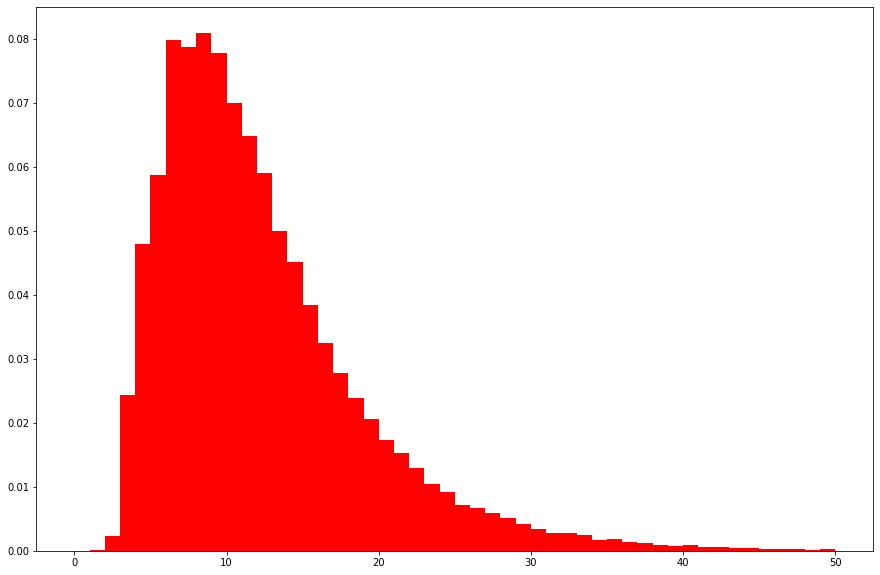

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,10))
plt.hist(train_word_counts , bins=50, range = [0,50], facecolor='r', density =True, label='train')


{'boxes': [<matplotlib.lines.Line2D at 0x7fe32cc78e90>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe32ccde990>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe32cd1d9d0>],
 'means': [<matplotlib.lines.Line2D at 0x7fe32cccfad0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe32cccf910>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe32d1832d0>,
  <matplotlib.lines.Line2D at 0x7fe32d1b5510>]}

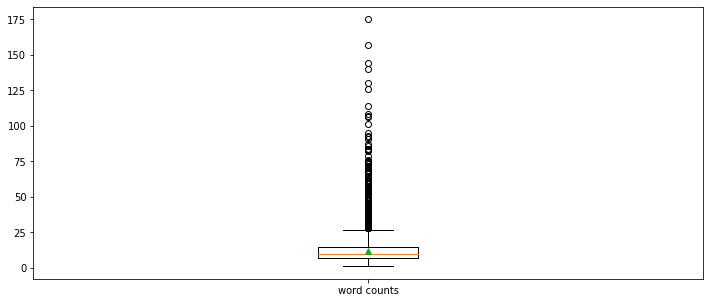

In [34]:
plt.figure(figsize=(12,5))
plt.boxplot(train_word_counts, labels=['word counts'], showmeans= True)

In [10]:
# 토크나이저를 거친후 eda진행
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir = 'bert_ckpt', do_lower=False)
train_bert_token_counts = train_set.apply(lambda x: len(tokenizer.tokenize(x)))

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [11]:
train_bert_token_counts

0        13
1        23
2        44
3        78
4        12
         ..
89995    12
89996    41
89997    13
89998    38
89999    30
Length: 90000, dtype: int64

In [41]:
print('문장 tokens 개수 최대 값: {}'.format(np.max(train_bert_token_counts)))
print('문장 tokens 개수 평균 값: {:.2f}'.format(np.mean(train_bert_token_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_counts)))
print('문장 tokens 개수 중간 값: {}'.format(np.median(train_bert_token_counts)))
print('문장 tokens 개수 제 1 사분위: {}'.format(np.percentile(train_bert_token_counts, 25)))
print('문장 tokens 개수 제 3 사분위: {}'.format(np.percentile(train_bert_token_counts, 75)))
print('문장 tokens 개수 99 퍼센트: {}'.format(np.percentile(train_bert_token_counts, 99)))

문장 tokens 개수 최대 값: 850
문장 tokens 개수 평균 값: 33.62
문장 tokens 개수 표준편차: 22.76
문장 tokens 개수 중간 값: 28.0
문장 tokens 개수 제 1 사분위: 19.0
문장 tokens 개수 제 3 사분위: 41.0
문장 tokens 개수 99 퍼센트: 111.0


In [12]:
# NER데이터 전처리
import tensorflow as tf
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)
BATCH_SIZE = 32
NUM_EPOCHS= 3
MAX_LEN =11 # EDA에서 추출한 MAX LENGTH
DATA_IN_PATH = '/content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_in/KOR'
DATA_OUT_PTH = '/content/'

In [13]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")

In [14]:
def read_file(input_path):
  with open(input_path, "r", encoding='utf-8') as f:
    sentences = []
    labels = []
    for line in f :
      split_line = line.strip().split("\t")
      sentences.append(split_line[0])
      labels.append(split_line[1])
    return sentences, labels

In [15]:
train_sentences, train_labels = read_file(DATA_TRAIN_PATH)

In [48]:
train_sentences

['금석객잔 여러분, 감사드립니다 .',
 '이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .',
 '7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권대회 출격권을 점유했다 .',
 '스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서 폭렬적인 평판을 모으고 있는데 치안정감들은 이 곡목에 출연해 인기인이 된 황정민 장두해 장정 풀 포츠가 퇴석했다며 송사를 보내고 있습니다 .',
 '보니까 저 옆에 사조가 있어요 .',
 '24회 최경운호의 좌익선상 28루타로 포문을 연 한화는 후속 서동원이 적시타를 날려 동점에 공성했다 .',
 '바둑선수가 묘하게 닮았는데요 .',
 "▲ '新플레이메이커' NO.7 박하성 - 1경기 30골30도움공수 운동경기가 풀리지 않을 때는 논란에 나서 슈팅까지 경쟁을 풀어나가는 존대성은 코리아바이오파크의 '신(新)해결사'로 터전 잡았다 .",
 '우려는 비현실이 됐다 .',
 '(이석무 귀재 smlee@mydaily.co.kr)',
 '서두가 역할의 소하젓은 다름아닌 쿠마리 씨였대요 .',
 '이렇게 검은색 판을 보여주면 자, 보세요 .',
 '아니， 그보다 고무와 재준 상호 본심을 밝혀내고 증오를 할 수 있을까요 ？',
 '투병중에 선민이 꿈꿔왔던 순수하지만 아픈 증오를 했는데요 .',
 '연변축구팀서 데뷔해 3년 자매원 이관 빚을 발한 임호성은 11년 만년 유망주에서 떡꼬치조림 상처를 꿰찼다 .',
 '그러던 어느 날 김대성은 어린 계절, 불초자 밑에서 꼬봉 노릇이나 하던 남덕기(유해진 분)가 라켓볼선수에 입후보한다는 돈반을 접하게 되고, 묘한 질투심에 사로잡힌다 .',
 '또한, 거세 암학회에 에이즈퇴치캠페인에 동참한 데 이어, 구제 동작을 하는 UN 산하기구인 UNHCR(유엔난민기구)의 에 동참할 계획이다 .',
 '시골의 작은 현으로서는 적지 않은 액수지만 탄광개발로 시의 수입금이 상년부터 28%씩 늘고 있어 감당할 수 있는 수준이라고 설계자

In [49]:
train_labels

['ORG-B O O O',
 'PER-B O O O TIM-B TIM-I CVL-B O O O O O',
 'EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O',
 'LOC-B NUM-B NUM-I O O O O O O O O O O O O O CVL-B O O O CVL-B O PER-B O O O CVL-B O O O O O',
 'O O O O O O',
 'NUM-B PER-B O NUM-B O O ORG-B O PER-B O O O O O',
 'CVL-B O O O',
 'O CVL-B NUM-B PER-B O NUM-B NUM-B O O O O O O O O O PER-B ORG-B CVL-B O O O',
 'O O O O',
 'PER-B CVL-B TRM-B',
 'O O CVL-B O PER-B O O',
 'O TRM-B O O O O O',
 'O O O O O O O O O O O O',
 'O O O O O O O O',
 'ORG-B O DAT-B ORG-B O O O PER-B DAT-B O CVL-B CVL-B O O O',
 'O O O PER-B O O O O O O O PER-B O CVL-B O O O O O O O O',
 'O DAT-B ORG-B EVT-B O O O O O O ORG-B O ORG-B O O O O',
 'O O O O O O O O O DAT-B NUM-B O O O O O O CVL-B O O',
 'PER-B O TRM-B O O O NUM-B CVL-B O',
 'ORG-B ORG-I ORG-B EVT-B LOC-B O',
 'O NUM-B O CVL-B O O O O O O',
 'O PER-B O NUM-B CVL-B O O',
 'LOC-B O O O O O O O O O O O LOC-B O O O O O O O',
 'PER-B O O O O CVL-B O',
 'O O CVL-B O LOC-B O O O O',
 'O ORG-B NUM-B 

In [16]:
train_ner_dict = {"sentence" : train_sentences, "label": train_labels}
train_ner_df = pd.DataFrame(train_ner_dict)

test_sentences, test_labels = read_file(DATA_TEST_PATH)
test_ner_dict = {"sentence" : test_sentences, "label": test_labels}
test_ner_df = pd.DataFrame(test_ner_dict)

In [51]:
len(train_ner_df)

81000

In [52]:
len(test_ner_df)

9000

In [17]:
# LABEL 불러오기
def get_labels(label_path):
  return [label.strip() for label in open(os.path.join(label_path), 'r', encoding = 'utf-8')]
ner_labels = get_labels(DATA_LABEL_PATH)

In [56]:
ner_labels

['UNK',
 'O',
 'PER-B',
 'PER-I',
 'FLD-B',
 'FLD-I',
 'AFW-B',
 'AFW-I',
 'ORG-B',
 'ORG-I',
 'LOC-B',
 'LOC-I',
 'CVL-B',
 'CVL-I',
 'DAT-B',
 'DAT-I',
 'TIM-B',
 'TIM-I',
 'NUM-B',
 'NUM-I',
 'EVT-B',
 'EVT-I',
 'ANM-B',
 'ANM-I',
 'PLT-B',
 'PLT-I',
 'MAT-B',
 'MAT-I',
 'TRM-B',
 'TRM-I']

In [21]:
print('개체명 인식라벨수 : {}'.format(len(ner_labels)))

개체명 인식라벨수 : 30


In [18]:
# 버트 토크나이저 설정
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir = ' bert-ckpt')
pad_token_id = tokenizer.pad_token_id
# 초기값은 0으로 설정
pad_token_label_id = 0 # 라벨이 시퀀스길에 맞춰져있기 때문에 주어진 입력의 길이 기반으로 패딩하기 위해 필요한값
cls_token_label_id = 0 # 학습시 라벨된 값 외에 학습에 영향을 미치지 않기 위해 설정되는 값
sep_token_label_id = 0 # 향후 손실값을 구성할때 시퀀스가 모두 영향을 미치는게 개체명 분야의 특성 때문에 인식에 필요한 값 외에는 모두 0으로 라벨을 지정해 학습에 영향을 미치지 않도록 함



Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [19]:
def bert_tokenizer(sent, MAX_LEN):
  encoded_dict = tokenizer.encode_plus(text= sent1, text_pair = sent2,   # encode_plus를 사용해서 세개의 값을 불러올 수 있음
                                       add_special_tokens = True,
                                       max_length = MAX_LEN,
                                       return_attention_mask = True,
                                       truncation =True)
  input_id = encoded_dict['input_id']
  attention_mask = encoded_dict['attention_mask']
  token_type_id = encoded_dict['token_type_ids']

  return input_id, attention_mask, token_type_id

In [ ]:
# 띄어쓰기에 맞게 구성돼 있는 버트 토크나이저에 맞는 형태로 변경하기 
# 버트 토크나이저로 분해된 개체명의 첫버트 토큰 부분을 시작을 상징하는 b, 나머지 부분은  내부를 상징하는 i로 지정하는 방식을 사용
# ex) 이순신 장군 : 이순신(per-b) + 장군(per-i)  /  # 이(per-b), ##순(per-i), ##신(per-i), 장(per-i), ##군(per-i)
def convert_label(words, labels_idx, ner_begin_label, max_seq_len):  # ner_begin_label에는 per-b, 과 같은 b로 시작하는 라벨값의 집합들을 의미함
  tokens = []
  labels_id = []

  for word, slot_label in zip(words, labels_idx):   #  words에서 단어리스트를 순차적으로 가져옴, 여기에 버트 토크나이저가 적용됨
    word_tokens = tokenizer.tokenize(word)  # word_tokens에 토크나이징된 결과가 할당되어 단어가 분절됨, 분절된 부분에 대한 새로운 개체명 라벨을 붙여야함
    
    if not word_tokens :   # 없으면 unk token으로 붙임, 정보가 없는 토큰
      word_tokens = [unk_token]  
    tokens.extend(word_tokens)

    #슬롯 라벨 값이 begin이면 i추가, 라벨을 붙이는 과정 진행됨
    if int(slot_label) in ner_begin_label:
      label_ids.extend([int(slot_label)] + [int(slot_label)+1] * (len(word_tokens) -1))
    else :
      label_ids.extend([int(slot_label)] * len(word_tokens))
    
  # [cls] , [sep] 설정
  special_tokens_count=2
  if len(label_ids) > max_seq_len - special_tokens_count:
    label_ids = label_ids[:(max_seq_len - special_tokens_count)] 
  
  #[sep] 토큰추가
  label_ids += [sep_token_label_id]

  # [cls]토큰 추가
  label_ids = [cls_token_label_id] + label_ids 

  padding_length = max_seq_len - len(label_ids)
  label_ids = label_ids + ([pad_token_label_id] * padding_length)

  return label_ids


In [20]:
ner_begin_label

NameError: ignored